# Прогнозирование временного ряда методом Theta Model

## Получение данных и ресэмплирование по месяцам

Text(0.5, 1.0, 'Alcohol Sales')

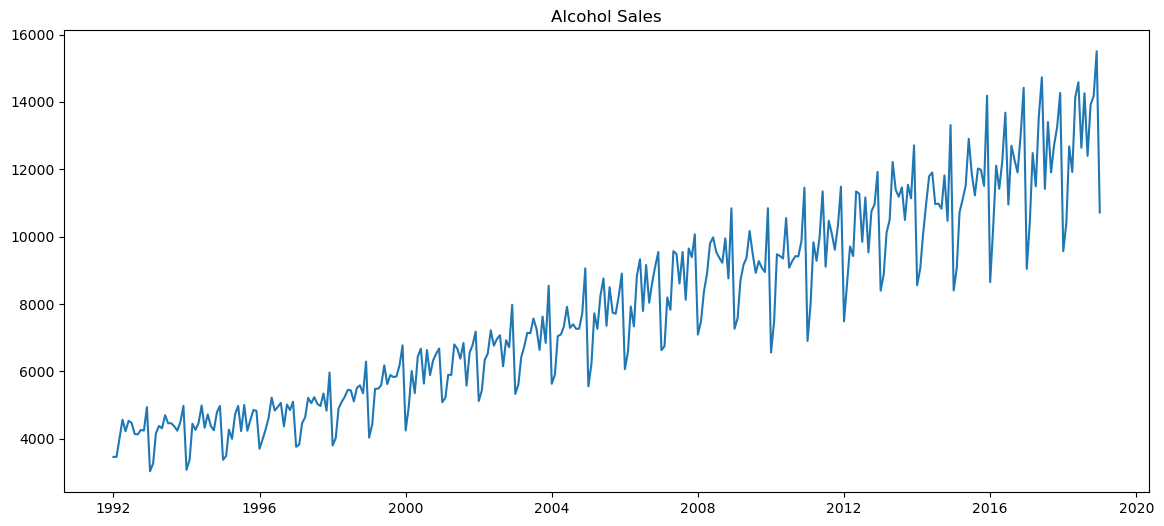

In [148]:
import pandas as pd
import matplotlib.pyplot as plt

filename = 'data/Alcohol_Sales.csv'
date = 'Date'
feature = 'Sales'

df = pd.read_csv(filename)
df[date] = pd.to_datetime(df[date], format='%Y-%m-%d')
df = df.set_index([date])

monthly_df = pd.DataFrame()
monthly_df[feature] = df[feature].resample('MS').mean()
data_size = monthly_df.shape[0]

plt.figure(figsize=(14, 6))
plt.plot(monthly_df.index, monthly_df[feature])
plt.title('Alcohol Sales')

<Axes: xlabel='Date'>

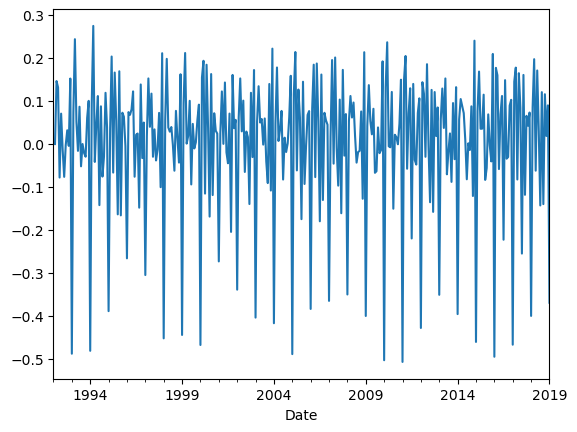

In [149]:
from numpy import log
monthly_df[feature] = monthly_df[feature].apply(log)
element0 = monthly_df[feature][0]
monthly_df[feature] = monthly_df[feature].diff()
monthly_df[feature].plot()

## Обучение собственной Theta модели

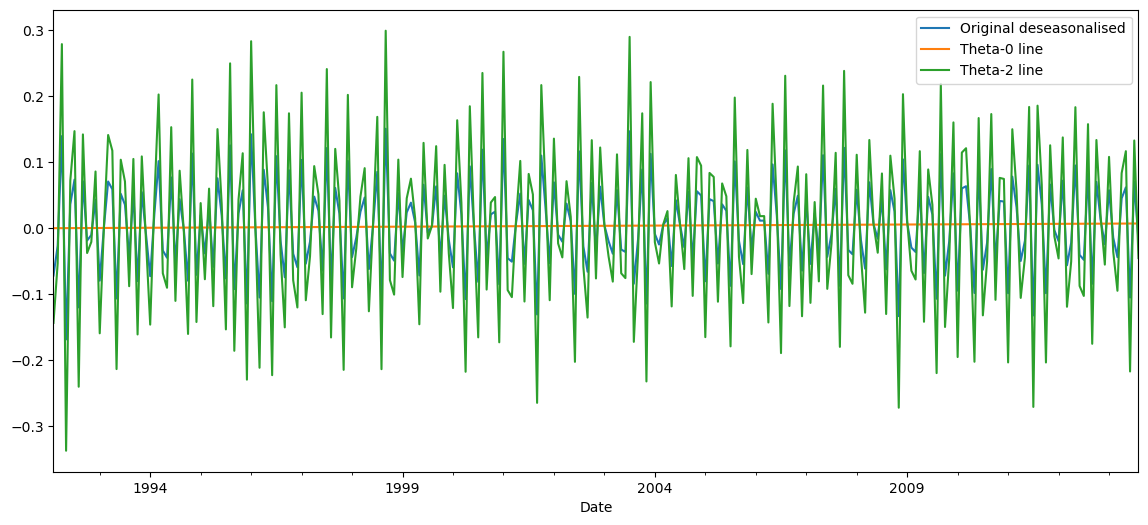

In [150]:
from theta_model import MyThetaModel

train_portion = 0.8
train_size = int(train_portion * data_size)
forecast_size = int((1 - train_portion) * data_size)
train_df = monthly_df[1:train_size]
season_period = 12

my_model = MyThetaModel(train_df[feature]).fit()
plt.figure(figsize=(14,6))
my_model.data.plot(label='Original deseasonalised')
my_model.theta0.plot(label='Theta-0 line')
my_model.theta2.plot(label='Theta-2 line')
plt.legend()

## Сравнение собственной и библиотечной реализаций

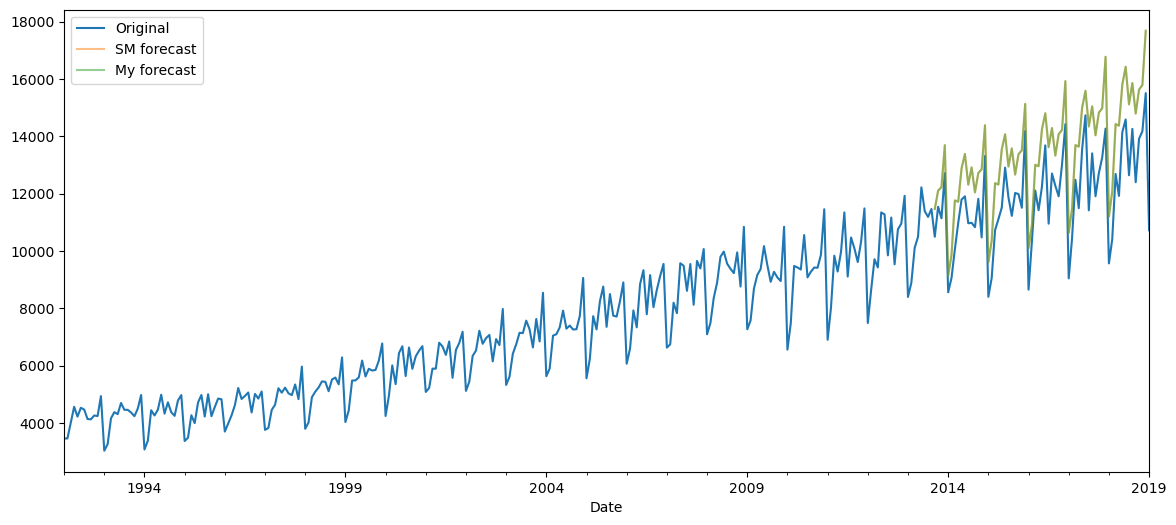

In [151]:
from statsmodels.tsa.forecasting.theta import ThetaModel
from numpy import exp

sm_model = ThetaModel(train_df, period=season_period).fit()
sm_forecast = sm_model.forecast(forecast_size)

my_forecast = my_model.forecast(forecast_size)

def restore_series(series, e0):
    series[0] = e0
    for i in range(1, len(series)):
        series[i] += series[i - 1]
    return series

monthly_df[feature] = restore_series(monthly_df[feature], element0)
sm_forecast = restore_series(sm_forecast, train_df[feature][-1])
my_forecast = restore_series(my_forecast, train_df[feature][-2])
plt.figure(figsize=(14,6))
monthly_df[feature].apply(exp).plot(label='Original')
sm_forecast.apply(exp).plot(label='SM forecast', alpha=0.5)
sm_forecast.apply(exp).plot(label='My forecast', alpha=0.5)
plt.legend()

## Сравнение ошибок обеих моделей

In [152]:
from sklearn.metrics import mean_absolute_percentage_error

true_data = monthly_df[-forecast_size:]
sm_pred_data = sm_forecast
my_pred_data = my_forecast[1:]

sm_mape = mean_absolute_percentage_error(true_data, sm_pred_data)
my_mape = mean_absolute_percentage_error(true_data, my_pred_data)
print('MAPE')
print('Statsmodels:', sm_mape)
print('My model:', my_mape)
print('Diff:', abs(sm_mape - my_mape))

MAPE
Statsmodels: 0.014568562335980428
My model: 0.07427594563295206
Diff: 0.05970738329697163
